In [2]:
import numpy as np
import sys
sys.setrecursionlimit(15000)

# Exercise 1: Tree method

## a)

In [3]:
class OctNode:
    """Stores the data for an octree node, and spawns its children if possible"""
    def __init__(self, center, size, masses, points, ids, leaves=[]):
        self.center = center                    # center of the node's box
        self.size = size                        # maximum side length of the box
        self.children = []                      # start out assuming that the node has no children
        
        Npoints = len(points)
        
        if Npoints == 1:
            # if we're down to one point, we need to store stuff in the node
            leaves.append(self)
            self.COM = points[0]
            self.mass = masses[0]
            self.id = ids[0]
            self.g = np.zeros(3)        # at each point, we will want the gravitational field
        else:
            self.GenerateChildren(points, masses, ids, leaves)     # if we have at least 2 points in the node,
        
    def GenerateChildren(self, points, masses, ids, leaves):
        """Generates the node's children"""
        octant_index = (points > self.center)  #does all comparisons needed to determine points' octants
        for i in range(2): #looping over the 8 octants
            for j in range(2):
                for k in range(2):
                    in_octant = np.all(octant_index == np.bool_([i,j,k]), axis=1)
                    if not np.any(in_octant): continue           # if no particles, don't make a node
                    dx = 0.5*self.size*(np.array([i,j,k])-0.5)   # offset between parent and child box centers
                    self.children.append(OctNode(self.center+dx,
                                                 self.size/2,
                                                 masses[in_octant],
                                                 points[in_octant],
                                                 ids[in_octant],
                                                 leaves))

The complexity of the tree construction is of order $\mathcal{O}(\log_2 N^{1/3})=\mathcal{O}(N\log N)$

## b)

The complexity to calculate the mass and COM of each cell in the the next step is $\mathcal{O}(N\log N)$ as well

## c)

For $\theta>1$ the complexity of calculating the gravitational force is $\mathcal{O}(N\log N)$. The whole algorithm therefore takes up a complexity of order $\mathcal{O}(N\log N)$.

# Exercise 2: Fast Fourier Transform

For caclulations by hand see PDF

In [4]:
def fft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if np.log2(N) % 1 > 0:
        raise ValueError("must be a power of 2")
        
    N_min = min(N, 2)
    
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))
    
    while X.shape[0] < N:
        X_even = X[:, :int(X.shape[1] / 2)]
        X_odd = X[:, int(X.shape[1] / 2):]
        terms = np.exp(-1j * np.pi * np.arange(X.shape[0]) / X.shape[0])[:, None]
        X = np.vstack([X_even + terms * X_odd, X_even - terms * X_odd])
        
    return X.ravel()

In [5]:
f = np.array([2,5,-7,2,3,-1,9,0])
print(fft(f))

[13.         +0.j          1.82842712+10.34314575j
  3.         -2.j         -3.82842712-21.65685425j
  1.         +0.j         -3.82842712+21.65685425j
  3.         +2.j          1.82842712-10.34314575j]


--- 0.00013136863708496094 seconds ---
--- 6.842613220214844e-05 seconds ---
--- 0.0002598762512207031 seconds ---
--- 0.00013637542724609375 seconds ---
--- 0.0002701282501220703 seconds ---
--- 0.0001862049102783203 seconds ---
--- 0.0002894401550292969 seconds ---
--- 0.00028228759765625 seconds ---
--- 0.0003542900085449219 seconds ---
--- 0.00040841102600097656 seconds ---
--- 0.0005717277526855469 seconds ---
--- 0.0007488727569580078 seconds ---
--- 0.0010437965393066406 seconds ---
--- 0.0017402172088623047 seconds ---
--- 0.0034551620483398438 seconds ---


Text(0, 0.5, 'Time t [seconds]')

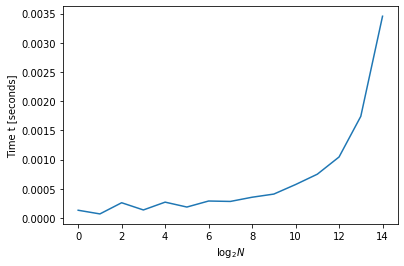

In [16]:
import time
import matplotlib.pyplot as plt
n = 15
times = np.arange(n)
result = []
for t in range(0,n):
    rnd = np.random.randn(int(2**t))
    start_time = time.time()
    fft(rnd)
    tmp = (time.time() - start_time)
    print("--- %s seconds ---" % tmp)
    result = np.append(result,tmp)
plt.plot(times,result)
plt.xlabel("$\log_2 N$")
plt.ylabel("Time t [seconds]")

# Exercise 3: PM-Scheme for Isolated Systems 

See PM.ipynb notebook

- For zero padding $=0$ the spherical particle cloud does not behave properly. One would expect that all particles collapse into a common center of mass but without zero padding the particles distribute nearly random. The reason for this is the Fourier transformation of the gravitational potential and the 2D convolution one has to calculate in order to determine the forces of each particle. 
- If we ass zero padding of 1.0 the spherical collapse occurs as expected. However, for value of zero padding too high, the simulation seem to take much longer for the collapse. 